In [1]:
import numpy as np
import pandas as pd
import matplotlib as plt
import re
import lightgbm as lgb
import datetime as dt
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.impute import SimpleImputer

In [120]:
clear = ["Opportunity_Name","ID","Last_Activity", "Brand", "Product_Type", "ASP_converted_Currency", 
          "Prod_Category_A", "Product_Category_B", "ASP_converted_Currency", "Product_Name", 
         "Delivery_Year", "Submitted_for_Approval", "Delivery_Terms", "Size", 
         "Price", "ASP_Currency", "Total_Amount_Currency", "Total_Taxable_Amount_Currency","Quote_Type", "Opportunity_Type",
         "Product_Family", "Account_Name", "Currency"] #"TRF"
dates = ["Account_Created_Date", "Opportunity_Created_Date", "Quote_Expiry_Date", "Last_Modified_Date", 
         "Planned_Delivery_Start_Date", "Planned_Delivery_End_Date", "Last_Activity", "Actual_Delivery_Date"]
target = ["Opportunity_ID", "Stage", "Sales_Contract_No"]

In [121]:
def preprocess(data, ada = False):
    
    # elimino caracteres prohibidos en los headers
    
    data = data.rename(columns = lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
        
    for d in dates:
        data[d] = pd.to_datetime(data[d])

    # agrego features
    
    data["Contacts"] = data.groupby("Opportunity_ID", sort = False)["Opportunity_ID"].transform("count")
    data["Delivery_Difference"] = (data["Planned_Delivery_End_Date"] - data["Planned_Delivery_Start_Date"]).dt.days == 0
    data["Same_Owner"] = (data.Opportunity_Owner == data.Account_Owner) & (data.Opportunity_Owner == data.Last_Modified_By)
    data["Has_Brand"] = data.Brand != "None"
    data["Has_Contract"] = data.Sales_Contract_No != "None"
    data["Has_Currency"] = data.Currency != "None"
    #data["Different_Country"] = (data.Billing_Country != data.Territory) & (data.Territory != "None")    
    #data.loc[data.TRF == 0, "TRF_Cat"] = 0
    #data.loc[(1 <= data.TRF) & (data.TRF <= 7), "TRF_Cat"] = 1
    #data.loc[data.TRF > 7, "TRF_Cat"] = 2
    #data["Sales"] = data.groupby("Account_Name", sort=False)["Opportunity_ID"].transform(lambda x: x.nunique())
    
    data["Concrete_Offer"] = ((data["Planned_Delivery_End_Date"] - data["Opportunity_Created_Date"]).dt.days) < 60
    #data["Offer_Duration"] = (data["Quote_Expiry_Date"] - data["Opportunity_Created_Date"]).dt.days    
    #data["Total_Volume"] = data.groupby("Opportunity_ID", sort = False)["Total_Amount"].transform("sum")
    data["ASP_max"] = data.groupby("Opportunity_ID", sort = False)["ASP"].transform("max")
    data["ASP_converted_max"] = data.groupby("Opportunity_ID", sort = False)["ASP_converted"].transform("max")
    data.drop(["ASP", "ASP_converted"], axis = 1, inplace = True)

    
    # fabri
    
    #data["Territory_Defined"] = data.Territory != "None"
    data["Past_Quote"] = (data["Last_Modified_Date"] - data["Quote_Expiry_Date"]).dt.days
    #data["Month"] = data.Month.str[-2:].astype(int)
    
    # casteo a categoricas varias columnas
    categorical = [x for x in data.columns if data[x].dtype == "object"]
    for c in categorical:       
        data[c] = data[c].astype('category')
        
    # limpio columnas
    
    data = data.drop(clear + dates, axis = 1)
    
    if "Stage" in data:
        data = data[(data.Stage == "Closed Won") | (data.Stage == "Closed Lost")]
        data.Stage = data.Stage.replace({"Closed Won": 1, "Closed Lost": 0})
    
    #data.drop(data[(data.Contacts > 1) & (data.ASP.isna())].index, inplace = True)
    
    # numeric encode de categoricals
    
    if ada:    
        label_encoder = LabelEncoder()
        cat_vars = [x for x in data.select_dtypes("category").columns if x != "Stage"]
        for col in cat_vars:
            data[col] = label_encoder.fit_transform(data[col])

        # elimino nans. strategy --> mean
        #imputer = SimpleImputer(strategy = "mean")
        #data.loc[data.Offer_Duration.isna(), "Offer_Duration"] = -100
        data.loc[data.Past_Quote.isna(), "Past_Quote"] = -100
        data.loc[data.Total_Amount.isna(), "Total_Amount"] = -100
        #data.loc[data.Total_Volume.isna(), "Total_Volume"] = -100
        data.loc[data.ASP_max.isna(), "ASP_max"] = -100
        data.loc[data.ASP_converted_max.isna(), "ASP_converted_max"] = -100
        
        #cols = data.columns
        #data = imputer.fit_transform(data)
        #data = pd.DataFrame(data, columns = cols)

    return (data)

In [122]:
data = pd.read_csv("Entrenamieto_ECI_2020.csv")

In [123]:
df = preprocess(data)

In [124]:
prep = preprocess(data, ada=True)

In [125]:
x_train, x_test, y_train, y_test = train_test_split(prep, prep.Stage, test_size = 0.3, random_state = 0)

In [126]:
model = xgb.XGBClassifier(learning_rate = 0.015,
                          subsample=0.7,
                          colsample_bytree=0.5,
                          scale_pos_weight=0.69,
                          random_state=42,
                          max_depth=8,
                          booster = 'gbtree',
                          objective = 'binary:logistic',
                          n_estimators = 5000)

In [127]:
model.fit(x_train.drop(target, axis = 1), 
          y_train, eval_metric = 'logloss', 
          eval_set=[(x_test.drop(target, axis = 1), y_test)], 
          early_stopping_rounds = 200)

[0]	validation_0-logloss:0.685692
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.67312
[2]	validation_0-logloss:0.660762
[3]	validation_0-logloss:0.65348
[4]	validation_0-logloss:0.641604
[5]	validation_0-logloss:0.634944
[6]	validation_0-logloss:0.628718
[7]	validation_0-logloss:0.622606
[8]	validation_0-logloss:0.611546
[9]	validation_0-logloss:0.605704
[10]	validation_0-logloss:0.595319
[11]	validation_0-logloss:0.58503
[12]	validation_0-logloss:0.575116
[13]	validation_0-logloss:0.565384
[14]	validation_0-logloss:0.555828
[15]	validation_0-logloss:0.550411
[16]	validation_0-logloss:0.541285
[17]	validation_0-logloss:0.536638
[18]	validation_0-logloss:0.527955
[19]	validation_0-logloss:0.523095
[20]	validation_0-logloss:0.518707
[21]	validation_0-logloss:0.514444
[22]	validation_0-logloss:0.506156
[23]	validation_0-logloss:0.498183
[24]	validation_0-logloss:0.490461
[25]	validation_0-logloss:0.482761
[26]	validation_0-logloss:0.475365

[230]	validation_0-logloss:0.117562
[231]	validation_0-logloss:0.117335
[232]	validation_0-logloss:0.116761
[233]	validation_0-logloss:0.116214
[234]	validation_0-logloss:0.11608
[235]	validation_0-logloss:0.115864
[236]	validation_0-logloss:0.115354
[237]	validation_0-logloss:0.115175
[238]	validation_0-logloss:0.114634
[239]	validation_0-logloss:0.114459
[240]	validation_0-logloss:0.114316
[241]	validation_0-logloss:0.11374
[242]	validation_0-logloss:0.113141
[243]	validation_0-logloss:0.112655
[244]	validation_0-logloss:0.112154
[245]	validation_0-logloss:0.112075
[246]	validation_0-logloss:0.111576
[247]	validation_0-logloss:0.111347
[248]	validation_0-logloss:0.111265
[249]	validation_0-logloss:0.111093
[250]	validation_0-logloss:0.110941
[251]	validation_0-logloss:0.110766
[252]	validation_0-logloss:0.110536
[253]	validation_0-logloss:0.110019
[254]	validation_0-logloss:0.109488
[255]	validation_0-logloss:0.108998
[256]	validation_0-logloss:0.108466
[257]	validation_0-logloss:0.1

[459]	validation_0-logloss:0.076554
[460]	validation_0-logloss:0.076523
[461]	validation_0-logloss:0.076445
[462]	validation_0-logloss:0.076352
[463]	validation_0-logloss:0.076298
[464]	validation_0-logloss:0.076274
[465]	validation_0-logloss:0.076227
[466]	validation_0-logloss:0.076162
[467]	validation_0-logloss:0.076098
[468]	validation_0-logloss:0.07598
[469]	validation_0-logloss:0.075873
[470]	validation_0-logloss:0.075822
[471]	validation_0-logloss:0.075788
[472]	validation_0-logloss:0.075732
[473]	validation_0-logloss:0.07568
[474]	validation_0-logloss:0.075575
[475]	validation_0-logloss:0.075467
[476]	validation_0-logloss:0.075381
[477]	validation_0-logloss:0.075326
[478]	validation_0-logloss:0.075274
[479]	validation_0-logloss:0.075197
[480]	validation_0-logloss:0.075171
[481]	validation_0-logloss:0.075081
[482]	validation_0-logloss:0.075064
[483]	validation_0-logloss:0.075005
[484]	validation_0-logloss:0.074954
[485]	validation_0-logloss:0.074918
[486]	validation_0-logloss:0.0

[688]	validation_0-logloss:0.066569
[689]	validation_0-logloss:0.066526
[690]	validation_0-logloss:0.066504
[691]	validation_0-logloss:0.066502
[692]	validation_0-logloss:0.066467
[693]	validation_0-logloss:0.066452
[694]	validation_0-logloss:0.066413
[695]	validation_0-logloss:0.066398
[696]	validation_0-logloss:0.066353
[697]	validation_0-logloss:0.066332
[698]	validation_0-logloss:0.066292
[699]	validation_0-logloss:0.06627
[700]	validation_0-logloss:0.066251
[701]	validation_0-logloss:0.066215
[702]	validation_0-logloss:0.066199
[703]	validation_0-logloss:0.066193
[704]	validation_0-logloss:0.066183
[705]	validation_0-logloss:0.066151
[706]	validation_0-logloss:0.066117
[707]	validation_0-logloss:0.066107
[708]	validation_0-logloss:0.066095
[709]	validation_0-logloss:0.066084
[710]	validation_0-logloss:0.066074
[711]	validation_0-logloss:0.066051
[712]	validation_0-logloss:0.066033
[713]	validation_0-logloss:0.066005
[714]	validation_0-logloss:0.06599
[715]	validation_0-logloss:0.0

[917]	validation_0-logloss:0.062823
[918]	validation_0-logloss:0.062812
[919]	validation_0-logloss:0.062793
[920]	validation_0-logloss:0.06278
[921]	validation_0-logloss:0.062778
[922]	validation_0-logloss:0.06277
[923]	validation_0-logloss:0.062748
[924]	validation_0-logloss:0.062735
[925]	validation_0-logloss:0.062729
[926]	validation_0-logloss:0.062733
[927]	validation_0-logloss:0.062733
[928]	validation_0-logloss:0.062718
[929]	validation_0-logloss:0.062696
[930]	validation_0-logloss:0.06266
[931]	validation_0-logloss:0.062671
[932]	validation_0-logloss:0.062679
[933]	validation_0-logloss:0.062664
[934]	validation_0-logloss:0.062668
[935]	validation_0-logloss:0.062658
[936]	validation_0-logloss:0.06263
[937]	validation_0-logloss:0.062619
[938]	validation_0-logloss:0.062608
[939]	validation_0-logloss:0.062608
[940]	validation_0-logloss:0.062614
[941]	validation_0-logloss:0.062626
[942]	validation_0-logloss:0.06261
[943]	validation_0-logloss:0.062619
[944]	validation_0-logloss:0.0626

[1142]	validation_0-logloss:0.061423
[1143]	validation_0-logloss:0.061417
[1144]	validation_0-logloss:0.06142
[1145]	validation_0-logloss:0.061393
[1146]	validation_0-logloss:0.06139
[1147]	validation_0-logloss:0.061395
[1148]	validation_0-logloss:0.061375
[1149]	validation_0-logloss:0.061361
[1150]	validation_0-logloss:0.061367
[1151]	validation_0-logloss:0.061358
[1152]	validation_0-logloss:0.061366
[1153]	validation_0-logloss:0.061371
[1154]	validation_0-logloss:0.061373
[1155]	validation_0-logloss:0.061345
[1156]	validation_0-logloss:0.061337
[1157]	validation_0-logloss:0.061346
[1158]	validation_0-logloss:0.061323
[1159]	validation_0-logloss:0.061333
[1160]	validation_0-logloss:0.061337
[1161]	validation_0-logloss:0.061331
[1162]	validation_0-logloss:0.061329
[1163]	validation_0-logloss:0.061329
[1164]	validation_0-logloss:0.061319
[1165]	validation_0-logloss:0.061327
[1166]	validation_0-logloss:0.061338
[1167]	validation_0-logloss:0.061322
[1168]	validation_0-logloss:0.061314
[11

[1364]	validation_0-logloss:0.061035
[1365]	validation_0-logloss:0.061019
[1366]	validation_0-logloss:0.061023
[1367]	validation_0-logloss:0.06103
[1368]	validation_0-logloss:0.061024
[1369]	validation_0-logloss:0.06101
[1370]	validation_0-logloss:0.061013
[1371]	validation_0-logloss:0.061004
[1372]	validation_0-logloss:0.061009
[1373]	validation_0-logloss:0.061003
[1374]	validation_0-logloss:0.061014
[1375]	validation_0-logloss:0.060999
[1376]	validation_0-logloss:0.061
[1377]	validation_0-logloss:0.060983
[1378]	validation_0-logloss:0.060989
[1379]	validation_0-logloss:0.061003
[1380]	validation_0-logloss:0.061024
[1381]	validation_0-logloss:0.06104
[1382]	validation_0-logloss:0.061044
[1383]	validation_0-logloss:0.061043
[1384]	validation_0-logloss:0.061044
[1385]	validation_0-logloss:0.061055
[1386]	validation_0-logloss:0.061045
[1387]	validation_0-logloss:0.061036
[1388]	validation_0-logloss:0.061033
[1389]	validation_0-logloss:0.061052
[1390]	validation_0-logloss:0.061048
[1391]	

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.015,
       max_delta_step=0, max_depth=8, min_child_weight=1, missing=None,
       n_estimators=5000, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=0.69, seed=None, silent=True,
       subsample=0.7)

In [128]:
res = model.predict_proba(x_test.drop(target, axis=1))[:,1]

In [129]:
x_test.Stage.head(10)

2040     0
4069     0
4230     1
578      1
12595    0
6042     1
2763     0
15932    0
2669     1
12803    0
Name: Stage, dtype: int64

In [130]:
for x in res[:10]:
    print("{:f}".format(x))

0.000468
0.004068
0.995190
0.990913
0.231738
0.974147
0.002084
0.000091
0.999656
0.001590


In [131]:
pred = pd.DataFrame(res, index = x_test.index, columns = ["Prediction"])

In [132]:
x_test_pred = x_test.join(pred)
answer = x_test_pred.groupby("Opportunity_ID")["Stage","Prediction"].mean()

In [133]:
log_loss(answer["Stage"], answer["Prediction"])

0.0703715265776997

28


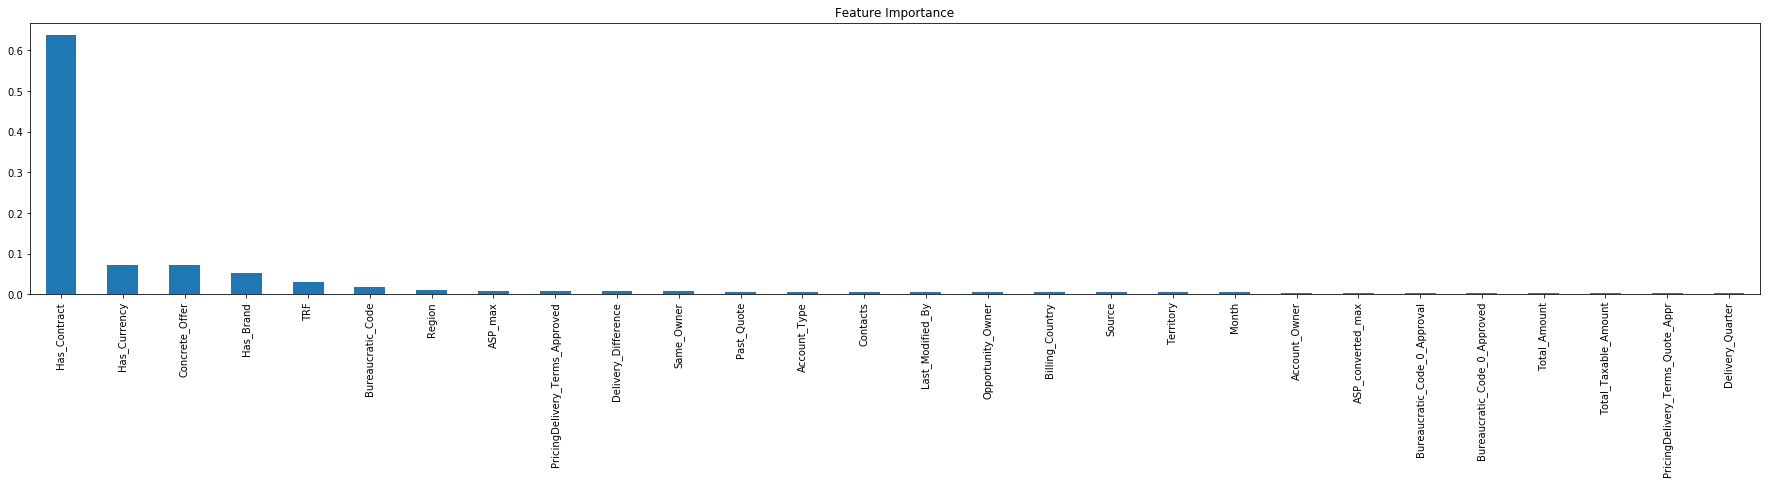

In [134]:
predictors = [x for x in x_train.drop(target, axis = 1).columns]
print len(predictors)
feat_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)
feat_imp = feat_imp[0:31]
plt.rcParams['figure.figsize'] = 31, 5
feat_imp.plot(kind = 'bar', title = 'Feature Importance')

In [135]:
print feat_imp

Has_Contract                        0.636849
Has_Currency                        0.073295
Concrete_Offer                      0.070993
Has_Brand                           0.052201
TRF                                 0.029647
Bureaucratic_Code                   0.017386
Region                              0.009487
ASP_max                             0.007280
PricingDelivery_Terms_Approved      0.007259
Delivery_Difference                 0.007044
Same_Owner                          0.006937
Past_Quote                          0.006416
Account_Type                        0.006356
Contacts                            0.006224
Last_Modified_By                    0.005465
Opportunity_Owner                   0.005416
Billing_Country                     0.005090
Source                              0.004678
Territory                           0.004588
Month                               0.004539
Account_Owner                       0.004341
ASP_converted_max                   0.004326
Bureaucrat

In [136]:
vali = pd.read_csv("Validacion_ECI_2020.csv")

In [137]:
validation = preprocess(vali, ada = True)

In [138]:
len(validation[validation.Contacts > 0])

2551

In [139]:
leak = ["Opportunity_ID", "Sales_Contract_No"]
pred = model.predict_proba(validation.drop(leak, axis = 1))

In [140]:
pred_vali = pred[:,1]

In [141]:
pred = pd.DataFrame(pred_vali, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [142]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [143]:
prev = pd.read_csv("submisson_ensamble_6.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9962032839969804

In [144]:
answer["Opportunity_ID"] = answer["Opportunity_ID"].astype(int)

In [145]:
adab = pd.read_csv("fabri/adab.csv", names = ["Opportunity_ID", "Prediction"])
adab["Prediction"].corr(answer["Prediction"])

0.9967411542975911

In [146]:
catb = pd.read_csv("fabri/catb2.csv", names = ["Opportunity_ID", "Prediction"])
catb["Prediction"].corr(answer["Prediction"])

0.9936506820554752

In [147]:
prev = pd.read_csv("fabri/xgb_imputer.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.998957023548115

In [87]:
catb["Prediction"].corr(adab["Prediction"])

0.9930529969961922

In [148]:
answer.to_csv("fabri/xgb_imputer_tweak.csv", index = False, header = False)

In [21]:
leak = ["Opportunity_ID", "Sales_Contract_No"]

In [66]:
FOLDS = 3
kf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state = 0)
pred_full = 0
cv_score = []
i = 1
X = prep.drop(target, axis = 1)
y = prep.Stage
model_list = []

for train_index,test_index in kf.split(X, y):
    
    print('{} of KFold {}'.format(i, kf.n_splits))
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = xgb.XGBClassifier(learning_rate = 0.015,
                          subsample=0.7,
                          colsample_bytree=0.5,
                          scale_pos_weight=0.69,
                          random_state=42,
                          max_depth=8,
                          booster = 'gbtree',
                          objective = 'binary:logistic',
                          n_estimators = 5000)
       
    model.fit(x_train, 
          y_train, eval_metric = 'logloss', 
          eval_set=[(x_test, y_test)], 
          early_stopping_rounds = 200)
    
    model_list += [model]
    score = log_loss(y_test, model.predict_proba(x_test)[:,1])
    print('LOG LOSS score:', score)
    cv_score.append(score)
    pred = model.predict_proba(validation.drop(leak, axis = 1))[:,1]
    pred_full += pred
    i += 1
pred_full /= FOLDS

1 of KFold 3
[0]	validation_0-logloss:0.685474
Will train until validation_0-logloss hasn't improved in 200 rounds.
[1]	validation_0-logloss:0.672571
[2]	validation_0-logloss:0.660092
[3]	validation_0-logloss:0.647969
[4]	validation_0-logloss:0.641562
[5]	validation_0-logloss:0.630046
[6]	validation_0-logloss:0.618892
[7]	validation_0-logloss:0.611945
[8]	validation_0-logloss:0.601169
[9]	validation_0-logloss:0.59073
[10]	validation_0-logloss:0.580493
[11]	validation_0-logloss:0.570561
[12]	validation_0-logloss:0.565061
[13]	validation_0-logloss:0.559653
[14]	validation_0-logloss:0.553742
[15]	validation_0-logloss:0.544499
[16]	validation_0-logloss:0.539228
[17]	validation_0-logloss:0.534273
[18]	validation_0-logloss:0.529403
[19]	validation_0-logloss:0.524348
[20]	validation_0-logloss:0.515695
[21]	validation_0-logloss:0.511124
[22]	validation_0-logloss:0.50277
[23]	validation_0-logloss:0.494673
[24]	validation_0-logloss:0.490198
[25]	validation_0-logloss:0.486126
[26]	validation_0-lo

[230]	validation_0-logloss:0.109804
[231]	validation_0-logloss:0.10926
[232]	validation_0-logloss:0.108637
[233]	validation_0-logloss:0.108465
[234]	validation_0-logloss:0.108303
[235]	validation_0-logloss:0.108122
[236]	validation_0-logloss:0.107522
[237]	validation_0-logloss:0.106992
[238]	validation_0-logloss:0.10642
[239]	validation_0-logloss:0.105915
[240]	validation_0-logloss:0.105295
[241]	validation_0-logloss:0.105135
[242]	validation_0-logloss:0.104948
[243]	validation_0-logloss:0.104435
[244]	validation_0-logloss:0.103912
[245]	validation_0-logloss:0.103746
[246]	validation_0-logloss:0.103205
[247]	validation_0-logloss:0.102665
[248]	validation_0-logloss:0.102159
[249]	validation_0-logloss:0.101639
[250]	validation_0-logloss:0.101152
[251]	validation_0-logloss:0.100667
[252]	validation_0-logloss:0.100513
[253]	validation_0-logloss:0.10034
[254]	validation_0-logloss:0.100166
[255]	validation_0-logloss:0.0997
[256]	validation_0-logloss:0.09919
[257]	validation_0-logloss:0.09877

[459]	validation_0-logloss:0.069516
[460]	validation_0-logloss:0.069472
[461]	validation_0-logloss:0.069396
[462]	validation_0-logloss:0.069328
[463]	validation_0-logloss:0.069233
[464]	validation_0-logloss:0.069138
[465]	validation_0-logloss:0.069058
[466]	validation_0-logloss:0.069023
[467]	validation_0-logloss:0.068986
[468]	validation_0-logloss:0.068895
[469]	validation_0-logloss:0.068811
[470]	validation_0-logloss:0.068781
[471]	validation_0-logloss:0.068709
[472]	validation_0-logloss:0.068641
[473]	validation_0-logloss:0.068545
[474]	validation_0-logloss:0.068539
[475]	validation_0-logloss:0.068474
[476]	validation_0-logloss:0.068406
[477]	validation_0-logloss:0.068372
[478]	validation_0-logloss:0.068321
[479]	validation_0-logloss:0.068276
[480]	validation_0-logloss:0.068223
[481]	validation_0-logloss:0.068127
[482]	validation_0-logloss:0.068107
[483]	validation_0-logloss:0.068067
[484]	validation_0-logloss:0.068058
[485]	validation_0-logloss:0.068016
[486]	validation_0-logloss:0

[688]	validation_0-logloss:0.06174
[689]	validation_0-logloss:0.061735
[690]	validation_0-logloss:0.061736
[691]	validation_0-logloss:0.061714
[692]	validation_0-logloss:0.061711
[693]	validation_0-logloss:0.061702
[694]	validation_0-logloss:0.061676
[695]	validation_0-logloss:0.061658
[696]	validation_0-logloss:0.061624
[697]	validation_0-logloss:0.061605
[698]	validation_0-logloss:0.061574
[699]	validation_0-logloss:0.061573
[700]	validation_0-logloss:0.06154
[701]	validation_0-logloss:0.061546
[702]	validation_0-logloss:0.061541
[703]	validation_0-logloss:0.061512
[704]	validation_0-logloss:0.061501
[705]	validation_0-logloss:0.061492
[706]	validation_0-logloss:0.061481
[707]	validation_0-logloss:0.061469
[708]	validation_0-logloss:0.061452
[709]	validation_0-logloss:0.061441
[710]	validation_0-logloss:0.061408
[711]	validation_0-logloss:0.061412
[712]	validation_0-logloss:0.061419
[713]	validation_0-logloss:0.061395
[714]	validation_0-logloss:0.061381
[715]	validation_0-logloss:0.0

[917]	validation_0-logloss:0.059107
[918]	validation_0-logloss:0.059108
[919]	validation_0-logloss:0.059109
[920]	validation_0-logloss:0.059092
[921]	validation_0-logloss:0.059093
[922]	validation_0-logloss:0.059079
[923]	validation_0-logloss:0.059071
[924]	validation_0-logloss:0.059059
[925]	validation_0-logloss:0.059048
[926]	validation_0-logloss:0.059053
[927]	validation_0-logloss:0.059056
[928]	validation_0-logloss:0.059048
[929]	validation_0-logloss:0.059054
[930]	validation_0-logloss:0.059056
[931]	validation_0-logloss:0.059036
[932]	validation_0-logloss:0.059034
[933]	validation_0-logloss:0.05905
[934]	validation_0-logloss:0.059038
[935]	validation_0-logloss:0.059038
[936]	validation_0-logloss:0.059032
[937]	validation_0-logloss:0.059003
[938]	validation_0-logloss:0.059018
[939]	validation_0-logloss:0.059019
[940]	validation_0-logloss:0.059022
[941]	validation_0-logloss:0.059019
[942]	validation_0-logloss:0.059028
[943]	validation_0-logloss:0.059017
[944]	validation_0-logloss:0.

[1142]	validation_0-logloss:0.058518
[1143]	validation_0-logloss:0.058531
[1144]	validation_0-logloss:0.058517
[1145]	validation_0-logloss:0.058511
[1146]	validation_0-logloss:0.058519
[1147]	validation_0-logloss:0.058518
[1148]	validation_0-logloss:0.058523
[1149]	validation_0-logloss:0.058539
[1150]	validation_0-logloss:0.058525
[1151]	validation_0-logloss:0.058522
[1152]	validation_0-logloss:0.05852
[1153]	validation_0-logloss:0.058515
[1154]	validation_0-logloss:0.058504
[1155]	validation_0-logloss:0.058497
[1156]	validation_0-logloss:0.058492
[1157]	validation_0-logloss:0.058496
[1158]	validation_0-logloss:0.058489
[1159]	validation_0-logloss:0.058496
[1160]	validation_0-logloss:0.0585
[1161]	validation_0-logloss:0.0585
[1162]	validation_0-logloss:0.05851
[1163]	validation_0-logloss:0.058512
[1164]	validation_0-logloss:0.058501
[1165]	validation_0-logloss:0.058479
[1166]	validation_0-logloss:0.058483
[1167]	validation_0-logloss:0.058483
[1168]	validation_0-logloss:0.058496
[1169]	

[1364]	validation_0-logloss:0.058512
[1365]	validation_0-logloss:0.058527
[1366]	validation_0-logloss:0.058527
[1367]	validation_0-logloss:0.058547
[1368]	validation_0-logloss:0.058538
[1369]	validation_0-logloss:0.058538
[1370]	validation_0-logloss:0.058535
[1371]	validation_0-logloss:0.058541
[1372]	validation_0-logloss:0.058529
[1373]	validation_0-logloss:0.058523
[1374]	validation_0-logloss:0.058521
[1375]	validation_0-logloss:0.05852
[1376]	validation_0-logloss:0.058515
[1377]	validation_0-logloss:0.058521
[1378]	validation_0-logloss:0.058521
[1379]	validation_0-logloss:0.058531
[1380]	validation_0-logloss:0.058546
[1381]	validation_0-logloss:0.05854
[1382]	validation_0-logloss:0.058549
[1383]	validation_0-logloss:0.058549
[1384]	validation_0-logloss:0.058556
[1385]	validation_0-logloss:0.058563
[1386]	validation_0-logloss:0.058574
[1387]	validation_0-logloss:0.058581
[1388]	validation_0-logloss:0.05858
[1389]	validation_0-logloss:0.058596
[1390]	validation_0-logloss:0.058597
[139

[149]	validation_0-logloss:0.161861
[150]	validation_0-logloss:0.160506
[151]	validation_0-logloss:0.159962
[152]	validation_0-logloss:0.159454
[153]	validation_0-logloss:0.158182
[154]	validation_0-logloss:0.156915
[155]	validation_0-logloss:0.156378
[156]	validation_0-logloss:0.155153
[157]	validation_0-logloss:0.154708
[158]	validation_0-logloss:0.153484
[159]	validation_0-logloss:0.153021
[160]	validation_0-logloss:0.15256
[161]	validation_0-logloss:0.152111
[162]	validation_0-logloss:0.150912
[163]	validation_0-logloss:0.149764
[164]	validation_0-logloss:0.148598
[165]	validation_0-logloss:0.148133
[166]	validation_0-logloss:0.147708
[167]	validation_0-logloss:0.147306
[168]	validation_0-logloss:0.146107
[169]	validation_0-logloss:0.144993
[170]	validation_0-logloss:0.144571
[171]	validation_0-logloss:0.143501
[172]	validation_0-logloss:0.143081
[173]	validation_0-logloss:0.142051
[174]	validation_0-logloss:0.141052
[175]	validation_0-logloss:0.139989
[176]	validation_0-logloss:0.

[378]	validation_0-logloss:0.078771
[379]	validation_0-logloss:0.078698
[380]	validation_0-logloss:0.078645
[381]	validation_0-logloss:0.078497
[382]	validation_0-logloss:0.078454
[383]	validation_0-logloss:0.07841
[384]	validation_0-logloss:0.078243
[385]	validation_0-logloss:0.078151
[386]	validation_0-logloss:0.077984
[387]	validation_0-logloss:0.077834
[388]	validation_0-logloss:0.077697
[389]	validation_0-logloss:0.077527
[390]	validation_0-logloss:0.07747
[391]	validation_0-logloss:0.077304
[392]	validation_0-logloss:0.077136
[393]	validation_0-logloss:0.077058
[394]	validation_0-logloss:0.076905
[395]	validation_0-logloss:0.076762
[396]	validation_0-logloss:0.076631
[397]	validation_0-logloss:0.076555
[398]	validation_0-logloss:0.076485
[399]	validation_0-logloss:0.076379
[400]	validation_0-logloss:0.076254
[401]	validation_0-logloss:0.076197
[402]	validation_0-logloss:0.076046
[403]	validation_0-logloss:0.075899
[404]	validation_0-logloss:0.075771
[405]	validation_0-logloss:0.0

[607]	validation_0-logloss:0.063854
[608]	validation_0-logloss:0.063832
[609]	validation_0-logloss:0.063779
[610]	validation_0-logloss:0.063771
[611]	validation_0-logloss:0.063749
[612]	validation_0-logloss:0.063689
[613]	validation_0-logloss:0.063672
[614]	validation_0-logloss:0.063602
[615]	validation_0-logloss:0.063591
[616]	validation_0-logloss:0.063562
[617]	validation_0-logloss:0.063535
[618]	validation_0-logloss:0.063479
[619]	validation_0-logloss:0.063446
[620]	validation_0-logloss:0.063409
[621]	validation_0-logloss:0.063377
[622]	validation_0-logloss:0.06332
[623]	validation_0-logloss:0.063286
[624]	validation_0-logloss:0.063257
[625]	validation_0-logloss:0.063232
[626]	validation_0-logloss:0.063177
[627]	validation_0-logloss:0.063155
[628]	validation_0-logloss:0.063124
[629]	validation_0-logloss:0.06309
[630]	validation_0-logloss:0.063077
[631]	validation_0-logloss:0.063032
[632]	validation_0-logloss:0.062989
[633]	validation_0-logloss:0.062981
[634]	validation_0-logloss:0.0

[836]	validation_0-logloss:0.058622
[837]	validation_0-logloss:0.058615
[838]	validation_0-logloss:0.058612
[839]	validation_0-logloss:0.058617
[840]	validation_0-logloss:0.058604
[841]	validation_0-logloss:0.058592
[842]	validation_0-logloss:0.058579
[843]	validation_0-logloss:0.058569
[844]	validation_0-logloss:0.058562
[845]	validation_0-logloss:0.058556
[846]	validation_0-logloss:0.058518
[847]	validation_0-logloss:0.05849
[848]	validation_0-logloss:0.058456
[849]	validation_0-logloss:0.058435
[850]	validation_0-logloss:0.05843
[851]	validation_0-logloss:0.058424
[852]	validation_0-logloss:0.058393
[853]	validation_0-logloss:0.05838
[854]	validation_0-logloss:0.05837
[855]	validation_0-logloss:0.058371
[856]	validation_0-logloss:0.05836
[857]	validation_0-logloss:0.058336
[858]	validation_0-logloss:0.058338
[859]	validation_0-logloss:0.058308
[860]	validation_0-logloss:0.058313
[861]	validation_0-logloss:0.058307
[862]	validation_0-logloss:0.058292
[863]	validation_0-logloss:0.0582

[1063]	validation_0-logloss:0.056889
[1064]	validation_0-logloss:0.056877
[1065]	validation_0-logloss:0.056869
[1066]	validation_0-logloss:0.056852
[1067]	validation_0-logloss:0.056845
[1068]	validation_0-logloss:0.056832
[1069]	validation_0-logloss:0.056833
[1070]	validation_0-logloss:0.056829
[1071]	validation_0-logloss:0.056831
[1072]	validation_0-logloss:0.056831
[1073]	validation_0-logloss:0.056815
[1074]	validation_0-logloss:0.05681
[1075]	validation_0-logloss:0.056819
[1076]	validation_0-logloss:0.056815
[1077]	validation_0-logloss:0.056797
[1078]	validation_0-logloss:0.056777
[1079]	validation_0-logloss:0.056785
[1080]	validation_0-logloss:0.056784
[1081]	validation_0-logloss:0.056767
[1082]	validation_0-logloss:0.056779
[1083]	validation_0-logloss:0.05677
[1084]	validation_0-logloss:0.056748
[1085]	validation_0-logloss:0.056737
[1086]	validation_0-logloss:0.056717
[1087]	validation_0-logloss:0.05672
[1088]	validation_0-logloss:0.056715
[1089]	validation_0-logloss:0.056724
[109

[1286]	validation_0-logloss:0.056245
[1287]	validation_0-logloss:0.056239
[1288]	validation_0-logloss:0.05624
[1289]	validation_0-logloss:0.05625
[1290]	validation_0-logloss:0.056249
[1291]	validation_0-logloss:0.056249
[1292]	validation_0-logloss:0.056258
[1293]	validation_0-logloss:0.05628
[1294]	validation_0-logloss:0.056273
[1295]	validation_0-logloss:0.056273
[1296]	validation_0-logloss:0.056272
[1297]	validation_0-logloss:0.056279
[1298]	validation_0-logloss:0.056275
[1299]	validation_0-logloss:0.056284
[1300]	validation_0-logloss:0.056275
[1301]	validation_0-logloss:0.056284
[1302]	validation_0-logloss:0.056282
[1303]	validation_0-logloss:0.056307
[1304]	validation_0-logloss:0.056314
[1305]	validation_0-logloss:0.056318
[1306]	validation_0-logloss:0.056308
[1307]	validation_0-logloss:0.056308
[1308]	validation_0-logloss:0.056321
[1309]	validation_0-logloss:0.056306
[1310]	validation_0-logloss:0.056315
[1311]	validation_0-logloss:0.05631
[1312]	validation_0-logloss:0.056304
[1313

[38]	validation_0-logloss:0.417876
[39]	validation_0-logloss:0.41495
[40]	validation_0-logloss:0.40887
[41]	validation_0-logloss:0.403028
[42]	validation_0-logloss:0.399892
[43]	validation_0-logloss:0.39708
[44]	validation_0-logloss:0.391288
[45]	validation_0-logloss:0.385743
[46]	validation_0-logloss:0.38323
[47]	validation_0-logloss:0.377873
[48]	validation_0-logloss:0.372616
[49]	validation_0-logloss:0.369933
[50]	validation_0-logloss:0.364836
[51]	validation_0-logloss:0.362287
[52]	validation_0-logloss:0.359779
[53]	validation_0-logloss:0.357403
[54]	validation_0-logloss:0.352551
[55]	validation_0-logloss:0.350317
[56]	validation_0-logloss:0.345681
[57]	validation_0-logloss:0.343402
[58]	validation_0-logloss:0.338798
[59]	validation_0-logloss:0.334318
[60]	validation_0-logloss:0.329997
[61]	validation_0-logloss:0.327934
[62]	validation_0-logloss:0.323786
[63]	validation_0-logloss:0.319512
[64]	validation_0-logloss:0.317661
[65]	validation_0-logloss:0.315844
[66]	validation_0-loglos

[269]	validation_0-logloss:0.09999
[270]	validation_0-logloss:0.099591
[271]	validation_0-logloss:0.099435
[272]	validation_0-logloss:0.099093
[273]	validation_0-logloss:0.098941
[274]	validation_0-logloss:0.098575
[275]	validation_0-logloss:0.098462
[276]	validation_0-logloss:0.098125
[277]	validation_0-logloss:0.097769
[278]	validation_0-logloss:0.097457
[279]	validation_0-logloss:0.097318
[280]	validation_0-logloss:0.096935
[281]	validation_0-logloss:0.096604
[282]	validation_0-logloss:0.096504
[283]	validation_0-logloss:0.096434
[284]	validation_0-logloss:0.096281
[285]	validation_0-logloss:0.096158
[286]	validation_0-logloss:0.09605
[287]	validation_0-logloss:0.095906
[288]	validation_0-logloss:0.095578
[289]	validation_0-logloss:0.09543
[290]	validation_0-logloss:0.095358
[291]	validation_0-logloss:0.095223
[292]	validation_0-logloss:0.095103
[293]	validation_0-logloss:0.094791
[294]	validation_0-logloss:0.094454
[295]	validation_0-logloss:0.094185
[296]	validation_0-logloss:0.09

[498]	validation_0-logloss:0.072776
[499]	validation_0-logloss:0.072741
[500]	validation_0-logloss:0.072646
[501]	validation_0-logloss:0.072556
[502]	validation_0-logloss:0.072487
[503]	validation_0-logloss:0.072424
[504]	validation_0-logloss:0.072417
[505]	validation_0-logloss:0.072348
[506]	validation_0-logloss:0.072319
[507]	validation_0-logloss:0.072243
[508]	validation_0-logloss:0.072233
[509]	validation_0-logloss:0.072119
[510]	validation_0-logloss:0.072015
[511]	validation_0-logloss:0.071976
[512]	validation_0-logloss:0.071953
[513]	validation_0-logloss:0.071919
[514]	validation_0-logloss:0.071858
[515]	validation_0-logloss:0.071799
[516]	validation_0-logloss:0.071731
[517]	validation_0-logloss:0.071695
[518]	validation_0-logloss:0.071659
[519]	validation_0-logloss:0.071635
[520]	validation_0-logloss:0.071581
[521]	validation_0-logloss:0.071553
[522]	validation_0-logloss:0.071489
[523]	validation_0-logloss:0.071477
[524]	validation_0-logloss:0.071451
[525]	validation_0-logloss:0

[727]	validation_0-logloss:0.065793
[728]	validation_0-logloss:0.065787
[729]	validation_0-logloss:0.065775
[730]	validation_0-logloss:0.065736
[731]	validation_0-logloss:0.065736
[732]	validation_0-logloss:0.065697
[733]	validation_0-logloss:0.065678
[734]	validation_0-logloss:0.065643
[735]	validation_0-logloss:0.065617
[736]	validation_0-logloss:0.065619
[737]	validation_0-logloss:0.065598
[738]	validation_0-logloss:0.0656
[739]	validation_0-logloss:0.065588
[740]	validation_0-logloss:0.065573
[741]	validation_0-logloss:0.06556
[742]	validation_0-logloss:0.065523
[743]	validation_0-logloss:0.065501
[744]	validation_0-logloss:0.065488
[745]	validation_0-logloss:0.065458
[746]	validation_0-logloss:0.065433
[747]	validation_0-logloss:0.065382
[748]	validation_0-logloss:0.065357
[749]	validation_0-logloss:0.065334
[750]	validation_0-logloss:0.06532
[751]	validation_0-logloss:0.065303
[752]	validation_0-logloss:0.065302
[753]	validation_0-logloss:0.065318
[754]	validation_0-logloss:0.065

[956]	validation_0-logloss:0.063591
[957]	validation_0-logloss:0.063577
[958]	validation_0-logloss:0.063572
[959]	validation_0-logloss:0.063556
[960]	validation_0-logloss:0.063563
[961]	validation_0-logloss:0.06357
[962]	validation_0-logloss:0.063563
[963]	validation_0-logloss:0.063561
[964]	validation_0-logloss:0.063556
[965]	validation_0-logloss:0.063539
[966]	validation_0-logloss:0.063538
[967]	validation_0-logloss:0.063534
[968]	validation_0-logloss:0.063524
[969]	validation_0-logloss:0.06352
[970]	validation_0-logloss:0.063509
[971]	validation_0-logloss:0.063509
[972]	validation_0-logloss:0.063503
[973]	validation_0-logloss:0.063501
[974]	validation_0-logloss:0.063494
[975]	validation_0-logloss:0.0635
[976]	validation_0-logloss:0.06349
[977]	validation_0-logloss:0.063484
[978]	validation_0-logloss:0.063495
[979]	validation_0-logloss:0.063493
[980]	validation_0-logloss:0.063487
[981]	validation_0-logloss:0.063481
[982]	validation_0-logloss:0.063467
[983]	validation_0-logloss:0.0634

[1180]	validation_0-logloss:0.063138
[1181]	validation_0-logloss:0.063144
[1182]	validation_0-logloss:0.063128
[1183]	validation_0-logloss:0.063131
[1184]	validation_0-logloss:0.063144
[1185]	validation_0-logloss:0.063141
[1186]	validation_0-logloss:0.063141
[1187]	validation_0-logloss:0.063136
[1188]	validation_0-logloss:0.063154
[1189]	validation_0-logloss:0.063157
[1190]	validation_0-logloss:0.063173
[1191]	validation_0-logloss:0.063179
[1192]	validation_0-logloss:0.063181
[1193]	validation_0-logloss:0.063201
[1194]	validation_0-logloss:0.063193
[1195]	validation_0-logloss:0.063203
[1196]	validation_0-logloss:0.063186
[1197]	validation_0-logloss:0.063189
[1198]	validation_0-logloss:0.063191
[1199]	validation_0-logloss:0.063199
[1200]	validation_0-logloss:0.063189
[1201]	validation_0-logloss:0.063162
[1202]	validation_0-logloss:0.063169
[1203]	validation_0-logloss:0.063161
[1204]	validation_0-logloss:0.063158
[1205]	validation_0-logloss:0.063168
[1206]	validation_0-logloss:0.063164
[

In [67]:
cv_score

[0.05835476854699909, 0.05622179984950779, 0.0630638120484095]

In [39]:
pred = pd.DataFrame(pred_full, index = validation.index, columns = ["Prediction"])
pred_vali = validation.join(pred)

In [40]:
answer = pd.DataFrame(pred_vali.groupby("Opportunity_ID", as_index = False)["Prediction"].mean())

In [41]:
answer.Opportunity_ID = answer.Opportunity_ID.astype("int32")

In [42]:
answer

,Opportunity_ID,Prediction
0,10689,0.996798
1,10690,0.990723
2,10691,0.962534
3,10692,0.971518
4,10693,0.982683
5,10694,0.983634
6,10695,0.072061
7,10696,0.081565
8,10697,0.150826
9,10698,0.025023


In [65]:
prev = pd.read_csv("fabri/xgb3.csv", names = ["Opportunity_ID", "Prediction"])
prev["Prediction"].corr(answer["Prediction"])

0.9980214949056684

In [68]:
pd.set_option('display.max_rows', 1000)
len(validation.loc[(validation.Contacts > 1) & (validation.Check > 0.5), ["Billing_Country", "Opportunity_ID", "ASP", "ASP_converted", "Delivery_Difference", "Offer_Duration", "Total_Amount", "Total_Taxable_Amount", "Total_offer"]])

54

In [66]:
validation["Check"] = abs(validation.Total_offer - validation.Total_Taxable_Amount)

In [6]:
prep["Total_Offer"] = prep.groupby("Opportunity_ID", sort = False)["Total_Amount"].transform("sum")

In [72]:
adab = pd.read_csv("fabri/adab.csv", names = ["Opportunity_ID", "Prediction"])

In [73]:
catb = pd.read_csv("fabri/catb2.csv", names = ["Opportunity_ID", "Prediction"])

In [75]:
check = validation.merge(adab, on = "Opportunity_ID")

In [77]:
check = check.merge(catb, on = "Opportunity_ID")

In [83]:
check[abs(check.Prediction_x - check.Prediction_y) > 0.1]

,Region,Territory,PricingDelivery_Terms_Quote_Appr,PricingDelivery_Terms_Approved,Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Source,Billing_Country,Opportunity_ID,Sales_Contract_No,Account_Owner,Opportunity_Owner,Account_Type,Currency,Last_Modified_By,Month,Delivery_Quarter,Total_Amount,Total_Taxable_Amount,Contacts,Delivery_Difference,Same_Owner,Has_Brand,Has_Contract,TRF_Cat,Sales,Concrete_Offer,Offer_Duration,Total_Volume,ASP_max,ASP_converted_max,Territory_Defined,Past_Quote,Prediction_x,Prediction_y
24,0,1,1,1,0,0,3,4,1,10697,799,13,2,0,1,3,13,2,86394.00,431970.00,5,False,False,False,False,0.0,15,False,-100.0,431970.00,0.340,0.34000,True,-100.0,0.119578,0.004990
25,0,1,1,1,0,0,3,4,1,10697,799,13,2,0,1,3,13,2,86394.00,431970.00,5,False,False,False,False,0.0,15,False,-100.0,431970.00,0.340,0.34000,True,-100.0,0.119578,0.004990
26,0,1,1,1,0,0,3,4,1,10697,799,13,2,0,1,3,13,2,86394.00,431970.00,5,False,False,False,False,0.0,15,False,-100.0,431970.00,0.340,0.34000,True,-100.0,0.119578,0.004990
27,0,1,1,1,0,0,3,4,1,10697,799,13,2,0,1,3,13,2,86394.00,431970.00,5,False,False,False,False,0.0,15,False,-100.0,431970.00,0.340,0.34000,True,-100.0,0.119578,0.004990
28,0,1,1,1,0,0,3,4,1,10697,799,13,2,0,1,3,13,2,86394.00,431970.00,5,False,False,False,False,0.0,15,False,-100.0,431970.00,0.340,0.34000,True,-100.0,0.119578,0.004990
36,0,1,1,1,0,0,3,4,1,10700,799,13,2,0,1,3,5,3,177870.00,533610.00,3,True,False,False,False,0.0,15,False,-100.0,533610.00,0.550,0.55000,True,-100.0,0.179112,0.007931
37,0,1,1,1,0,0,3,4,1,10700,799,13,2,0,1,3,5,3,177870.00,533610.00,3,True,False,False,False,0.0,15,False,-100.0,533610.00,0.550,0.55000,True,-100.0,0.179112,0.007931
38,0,1,1,1,0,0,3,4,1,10700,799,13,2,0,1,3,5,3,177870.00,533610.00,3,True,False,False,False,0.0,15,False,-100.0,533610.00,0.550,0.55000,True,-100.0,0.179112,0.007931
39,0,1,1,1,0,0,3,10,1,10701,799,13,2,0,1,0,5,3,177870.00,533610.00,3,True,False,False,False,0.0,17,False,-100.0,533610.00,0.550,0.55000,True,-100.0,0.149125,0.008365
40,0,1,1,1,0,0,3,10,1,10701,799,13,2,0,1,0,5,3,177870.00,533610.00,3,True,False,False,False,0.0,17,False,-100.0,533610.00,0.550,0.55000,True,-100.0,0.149125,0.008365
